# Raw ensemble Performance

This notebook is used to calculate the CRPS of the Raw Ensemble

In [1]:
import pandas as pd
import os

import sys
sys.path.append('../utils')
import helpers

## Data cleaning
Exclude stations above 1,000 m and with lots of missing information

In [2]:
data = pd.read_feather(os.path.join('..', 'ens_fc_t2m_complete.feather'))  # Ensemble forecasts
data2 = helpers.load_data(os.path.join('..', 'data_RL18.feather'))  # Reduced ensemble forecasts
data2.reset_index(drop=True, inplace=True)

In [3]:
wrong_to_right_id = {value:i for i,value in enumerate(data.station.drop_duplicates())}
data.station = data.station.apply(lambda x: wrong_to_right_id[x])

In [4]:
# sort by date and station
data = data.sort_values(by=['date', 'station'])
data2 = data2.sort_values(by=['date', 'station'])

In [5]:
# clean data
data2_clean = helpers.clean_data(data2)
data_clean = data.iloc[data2_clean.index]

In [6]:
# check if everything worked fine
assert all(data_clean.station == data2_clean.station.values)

## CRPS
Compute CRPS on test Data (2016)

In [7]:
from hydrostats import ens_metrics

In [8]:
data_clean = data_clean[data_clean.date.dt.year==2016]
data2_clean = data2_clean[data2_clean.date.dt.year==2016]

In [9]:
ens = data_clean.iloc[:,3:].to_numpy()
obs = data_clean.iloc[:,2].to_numpy()

In [10]:
crps = ens_metrics.ens_crps(obs, ens)

In [11]:
crpsMean_2016 = crps['crpsMean']
print(crpsMean_2016)

1.1492074238506274


## Plot

Plot of ensemble vs actual observation

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline
plt.style.use('default')
plt.rcParams.update({'font.size': 12})

In [13]:
def jitter_dots(dots):
    offsets = dots.get_offsets()
    jittered_offsets = offsets
    # only jitter in the x-direction
    jittered_offsets[:, 0] += np.random.uniform(-0.1, 0.1, offsets.shape[0])
    dots.set_offsets(jittered_offsets)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


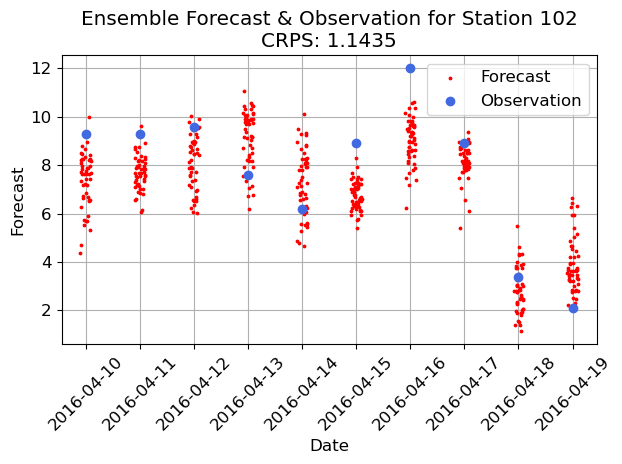

In [14]:
station = 102
days = 10
start = 100

df_station = data_clean[data_clean.station == station]
df_station = df_station.iloc[start:start+days,:]

# Crps of the n days
crps = ens_metrics.ens_crps(df_station.obs.to_numpy(), df_station.iloc[:,3:53].to_numpy())
crpsMean = crps["crpsMean"]

forecasts = value_vars = [col for col in df_station.columns if col.startswith('X')]
df_ens = pd.melt(df_station, id_vars=["date"], value_vars=forecasts, var_name="member", value_name="forecast")

fig, ax = plt.subplots()

dots = ax.scatter(df_ens.date, df_ens.forecast, color='red', s=3, label="Forecast")
jitter_dots(dots)
ax.scatter(df_station.date, df_station.obs, label="Observation", color="royalblue")

ax.set_axisbelow(True)  # This setting places the grid lines behind the data
ax.grid(True)


plt.xlabel('Date')
plt.ylabel('Forecast')
plt.title(f"Ensemble Forecast & Observation for Station {station}\nCRPS: {'{0:.4f}'.format(crpsMean)}")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig(f"../gnn/plots/example_raw_ensemble.eps", format='eps', bbox_inches='tight')

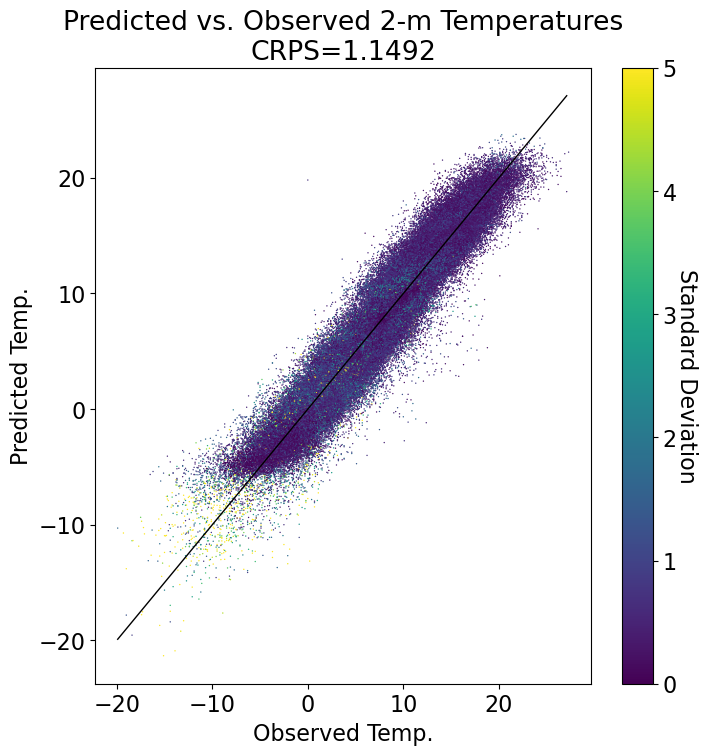

In [15]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8,8))
plt.plot(np.arange(np.min(data2_clean.obs),np.max(data2_clean.obs),1), np.arange(np.min(data2_clean.obs),np.max(data2_clean.obs),1),linewidth=1, color="black")  # line
plt.scatter(data2_clean.obs, data2_clean.t2m_mean, c=data2_clean.t2m_var, s=1, linewidth=0, cmap="viridis", vmin=0, vmax=5, rasterized=True)


cbar = plt.colorbar()
cbar.set_label('Standard Deviation', rotation=270, labelpad=15)
plt.xlabel('Observed Temp.')
plt.ylabel('Predicted Temp.')
plt.title(f"Predicted vs. Observed 2-m Temperatures\nCRPS={crpsMean_2016:.4f}")
plt.savefig(f"../gnn/plots/predsObs_raw_ensemble.pdf", dpi=600, format='pdf', bbox_inches='tight')

## PIT

In [16]:
from scipy.stats import norm

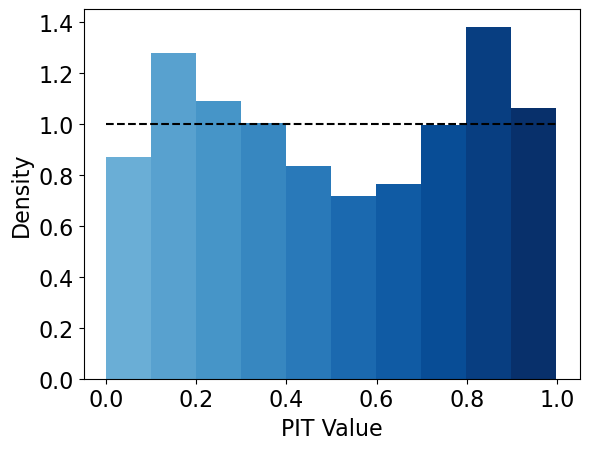

In [17]:
# Create Normal distribution based on the ensemble
mu = np.mean(ens)
sigma = np.sqrt(np.var(ens))

# Usual PIT procedure
probs = norm.cdf(obs.flatten(), loc=mu.flatten(), scale=sigma.flatten())  # scale is standard deviation
n, bins, patches = plt.hist(probs, bins=10, density=True)

# colors
cm = mpl.colormaps['Blues']
bin_centers = 0.5 * (bins[:-1] + bins[1:])

# scale values to interval [0,1]
col = bin_centers - min(bin_centers)
col /= (max(col))

def scale_interval(value, min_in, max_in, min_out, max_out):
    # Scale value from [min_in, max_in] to [min_out, max_out]
    scaled_value = min_out + (value - min_in) * (max_out - min_out) / (max_in - min_in)
    return scaled_value

col = scale_interval(col, 0, 1, 0.5,1)

for c, p in zip(col, patches):
    plt.setp(p, 'facecolor', cm(c))

plt.hlines(xmin=0,xmax=1, y=1, colors="black", linestyles="--")
plt.xlabel('PIT Value')
plt.ylabel('Density')
plt.savefig(f"../gnn/plots/PIT_raw_ensemble.eps", format='eps', bbox_inches='tight')